<a href="https://colab.research.google.com/github/esdrasfelipe07/precificacao-imoveis-ames/blob/main/Precificacao_Imoveis_Ames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Machine Learning — Precificação de Imóveis (Ames Housing)

Este notebook implementa um modelo de Machine Learning Supervisionado  
para prever o preço de venda de casas no dataset **Ames Housing**.

## Objetivos
- Realizar pré-processamento completo e adequado.
- Comparar diferentes modelos de regressão:
  - Linear Regression
  - Ridge
  - Lasso
  - Random Forest
- Utilizar Pipelines e ColumnTransformer (sem data leakage).
- Avaliar desempenho usando **RMSE** e **R²**.
- Identificar o melhor modelo e interpretar suas principais features.

## Importações e carregamento do Dataset

In [ ]:
# Importações e Configurações Iniciais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas do Scikit-Learn para pré-processamento e modelagem
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Modelos de Regressão
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Utilitário para carregar dataset (caso não haja arquivo local)
from sklearn.datasets import fetch_openml

# Configuração de estilo e supressão de avisos
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

print("Ambiente configurado e bibliotecas importadas.")

Ambiente configurado e bibliotecas importadas.


In [ ]:
# Carregamento do Dataset (Ames Housing)
print("Carregando dataset")

try:
    # 1. Tenta ler arquivo local
    df = pd.read_csv('train.csv')
    print("Sucesso: Arquivo local 'train.csv' carregado.")
except FileNotFoundError:
    # 2. Se não tiver arquivo, baixa direto do OpenML pelo ID oficial
    print("Arquivo local não encontrado. Baixando Ames Housing do OpenML...")
    housing = fetch_openml(data_id=1083, as_frame=True, parser="auto")
    df = housing.frame
    print("Sucesso: Dados baixados do OpenML.")

print(f"Dimensões: {df.shape}")
display(df.head())

Carregando dataset
Sucesso: Arquivo local 'train.csv' carregado.
Dimensões: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Limpeza Preliminar e Remoção de Outliers


In [ ]:
# Remoção de Outliers:
# Imóveis com área habitável muito grande (> 4000 sqft) e preço baixo são anomalias
# estatísticas que distorcem a regressão. Removemos para melhorar a generalização.
if 'GrLivArea' in df.columns and 'SalePrice' in df.columns:
    initial_shape = df.shape
    df = df[df['GrLivArea'] < 4000]
    print(f"Outliers removidos. Dimensão alterada de {initial_shape} para {df.shape}.")

# Correção de Tipagem:
# 'MSSubClass' são códigos numéricos que representam categorias (ex: 20, 60).
# Convertemos para string para que o modelo não os interprete como grandezas matemáticas.
if 'MSSubClass' in df.columns:
    df['MSSubClass'] = df['MSSubClass'].astype(str)

print("Limpeza preliminar concluída.")

Outliers removidos. Dimensão alterada de (1460, 81) para (1456, 81).
Limpeza preliminar concluída.


## Divisão de Dados e Transformação do Alvo

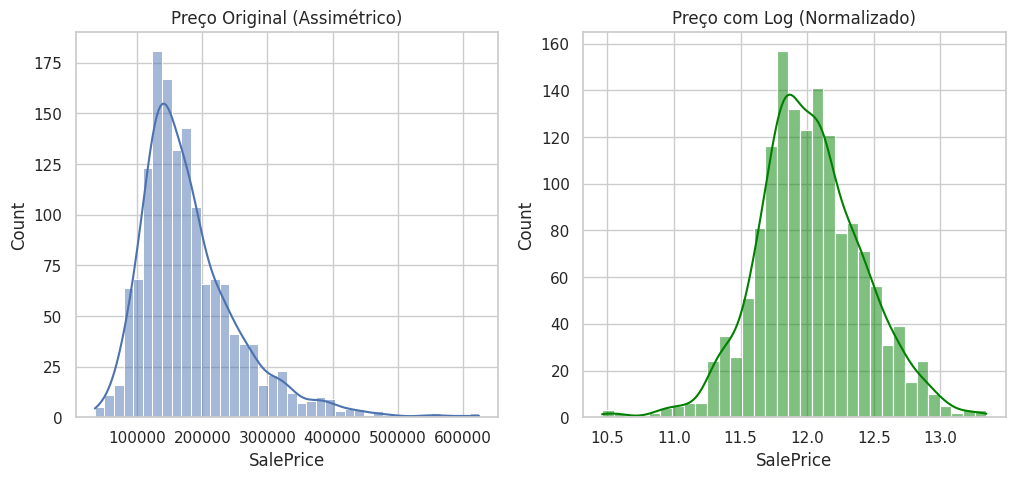

Dados divididos. Treino: (1164, 79), Teste: (292, 79)


In [ ]:
# Remover linhas sem o alvo (apenas precaução)
df = df.dropna(subset=['SalePrice'])

# Separação das Features (X) e do Alvo (y)
X = df.drop(['SalePrice', 'Id'], axis=1, errors='ignore')
y = df['SalePrice']

# Transformação Logarítmica:
# Preços de imóveis geralmente têm assimetria positiva. O log normaliza a distribuição,
# melhorando significativamente a performance de modelos lineares.
y_log = np.log1p(y)

# Visualização da distribuição do alvo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y, kde=True).set_title("Preço Original (Assimétrico)")
plt.subplot(1, 2, 2)
sns.histplot(y_log, kde=True, color='green').set_title("Preço com Log (Normalizado)")
plt.show()

# Divisão Treino/Teste (80% Treino, 20% Teste)
# random_state=42 garante reprodutibilidade
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

print(f"Dados divididos. Treino: {X_train.shape}, Teste: {X_test.shape}")

## Categorização de Variáveis para Engenharia de Atributos

In [ ]:
# 1. Variáveis Numéricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 2. Variáveis Ordinais (Qualidade com hierarquia)
# Estas colunas possuem uma ordem intrínseca de valor.
ordinal_features = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
]

# Definição da ordem hierárquica (do menor valor para o maior)
# O modelo aprenderá que 'Ex' > 'Gd' > 'TA' > 'Fa' > 'Po' > 'None'
quality_order = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_categories = [quality_order] * len(ordinal_features)

# 3. Variáveis Nominais (Categóricas sem ordem)
# Todas as colunas de texto que NÃO estão na lista ordinal (ex: Bairro)
nominal_features = [col for col in X_train.select_dtypes(include=['object']).columns
                    if col not in ordinal_features]

print(f"Total Numéricas: {len(numeric_features)}")
print(f"Total Ordinais: {len(ordinal_features)}")
print(f"Total Nominais: {len(nominal_features)}")

Total Numéricas: 35
Total Ordinais: 10
Total Nominais: 34


## Construção dos Pipelines de Pré-processamento


In [ ]:
# Pipeline Numérico:
# - Imputação: Mediana (robusto a outliers)
# - Escala: StandardScaler (Média 0, Desvio Padrão 1)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline Ordinal:
# - Imputação: Constante 'None'
# - Codificação: OrdinalEncoder (mapeia texto para números respeitando a ordem definida)
ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OrdinalEncoder(categories=ordinal_categories,
                               handle_unknown='use_encoded_value',
                               unknown_value=-1))
])

# Pipeline Nominal:
# - Imputação: Constante 'missing'
# - Codificação: OneHotEncoder (cria colunas binárias para cada categoria)
# - handle_unknown='ignore': Evita erros se uma categoria nova aparecer no teste
nom_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Processador Central (ColumnTransformer)
# Aplica o pipeline correto para cada grupo de colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('ord', ord_pipeline, ordinal_features),
        ('nom', nom_pipeline, nominal_features)
    ],
    remainder='drop' # Descarta colunas não listadas (ex: IDs)
)

print("Pipelines de pré-processamento construídos com sucesso.")

Pipelines de pré-processamento construídos com sucesso.


## Configuração da Grade de Modelos e Hiperparâmetros

In [ ]:
# Dicionário contendo a configuração de cada modelo para otimização
models_config = {
    # Modelo Baseline (Referência)
    "Regressão Linear": {
        "model": LinearRegression(),
        "params": {} # LinearRegression padrão não requer ajuste de hiperparâmetros
    },

    # Ridge (Regularização L2): Penaliza coeficientes altos, útil para multicolinearidade
    "Ridge": {
        "model": Ridge(),
        "params": {
            "regressor__alpha": [0.1, 1.0, 10.0, 50.0] # Força da regularização
        }
    },

    # Lasso (Regularização L1): Pode zerar coeficientes, realizando seleção de features
    "Lasso": {
        "model": Lasso(max_iter=10000), # Aumentamos iterações para garantir convergência
        "params": {
            "regressor__alpha": [0.0001, 0.0005, 0.001, 0.01]
        }
    },

    # Random Forest: Modelo não-linear robusto baseado em ensemble de árvores
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "regressor__n_estimators": [100, 200], # Quantidade de árvores
            "regressor__max_depth": [None, 20],    # Profundidade máxima (controle de overfitting)
            "regressor__min_samples_split": [2, 5] # Mínimo de amostras para dividir um nó
        }
    }
}

print("Configurações de modelos e hiperparâmetros definidas.")

Configurações de modelos e hiperparâmetros definidas.


## Execução do Treinamento e Avaliação (GridSearch)

In [ ]:
results_data = []
best_models = {} # Armazena os modelos treinados para uso posterior

print("Iniciando otimização e treinamento...")
print("-" * 100)
print(f"{'Modelo':<20} | {'Melhores Parâmetros (Resumo)':<35} | {'RMSE ($)':<15} | {'R²':<10}")
print("-" * 100)

for model_name, config in models_config.items():
    # 1. Pipeline Completo: Pré-processamento + Modelo
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])

    # 2. Configuração do GridSearchCV
    # cv=5: Validação cruzada com 5 partes
    # scoring: Otimiza buscando o menor erro quadrático (negativo)
    grid = GridSearchCV(
        full_pipeline,
        config['params'],
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1 # Usa todos os núcleos do processador
    )

    # 3. Treinamento
    grid.fit(X_train, y_train)

    # 4. Seleção do Melhor Modelo
    best_model = grid.best_estimator_
    best_models[model_name] = best_model

    # 5. Avaliação Final no Conjunto de Teste
    y_pred_log = best_model.predict(X_test)

    # Reverte o Log (np.expm1) para calcular erro em Dólares reais
    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred_log)

    # Cálculo das métricas
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2 = r2_score(y_test_real, y_pred_real)

    # Formatação para exibição
    best_params_str = str(grid.best_params_).replace("regressor__", "")
    if len(best_params_str) > 33: best_params_str = best_params_str[:30] + "..."

    print(f"{model_name:<20} | {best_params_str:<35} | {rmse:<12,.2f} | {r2:<10.4f}")


    # Salva resultados
    results_data.append({
        "Modelo": model_name,
        "RMSE": rmse,
        "R2": r2,
        "Params": grid.best_params_
    })

Iniciando otimização e treinamento...
----------------------------------------------------------------------------------------------------
Modelo               | Melhores Parâmetros (Resumo)        | RMSE ($)        | R²        
----------------------------------------------------------------------------------------------------
Regressão Linear     | {}                                  | 20,749.65    | 0.9180    
Ridge                | {'alpha': 50.0}                     | 19,775.48    | 0.9255    
Lasso                | {'alpha': 0.001}                    | 19,211.83    | 0.9297    
Random Forest        | {'max_depth': 20, 'min_samples...   | 25,199.45    | 0.8790    


## Visualização Comparativa dos Resultados


Resumo Final de Desempenho:


,Modelo,RMSE,R2
2,Lasso,19211.830966,0.929675
1,Ridge,19775.479812,0.925488
0,Regressão Linear,20749.645045,0.917966
3,Random Forest,25199.453826,0.879009


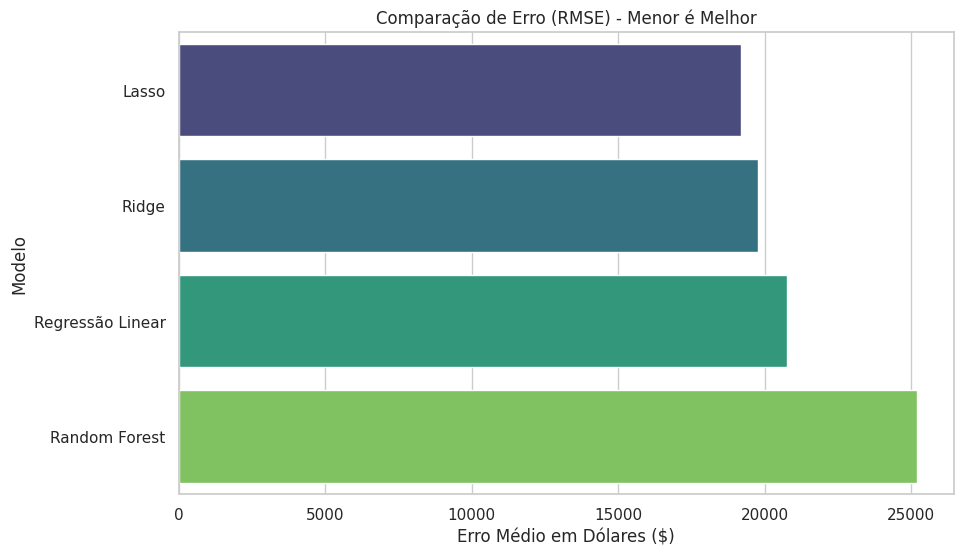

In [ ]:
# Criação de DataFrame ordenado pelo RMSE (menor erro primeiro)
results_df = pd.DataFrame(results_data).sort_values(by="RMSE")

# Exibição da Tabela Resumo
print("\nResumo Final de Desempenho:")
display(results_df[["Modelo", "RMSE", "R2"]])

# Gráfico de Barras para Comparação Visual do Erro
plt.figure(figsize=(10, 6))
sns.barplot(x="RMSE", y="Modelo", data=results_df, palette="viridis")
plt.title("Comparação de Erro (RMSE) - Menor é Melhor")
plt.xlabel("Erro Médio em Dólares ($)")
plt.show()

## Importância das Variáveis (Feature Importance)

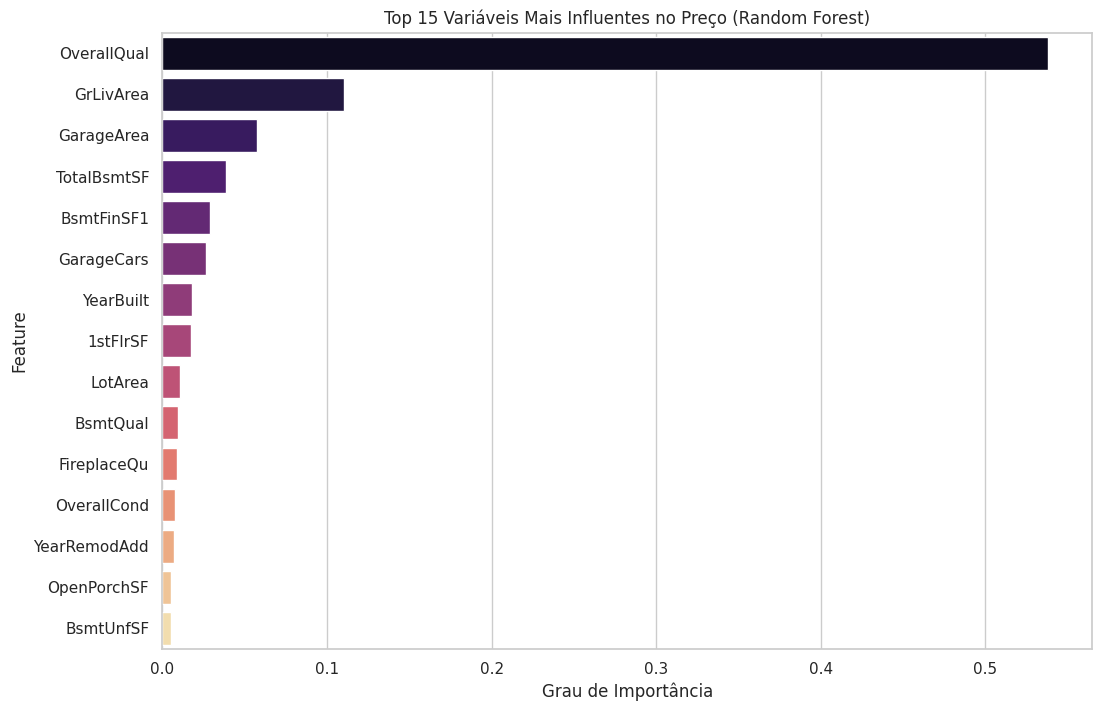

In [ ]:
# Realiza a análise apenas se o Random Forest foi treinado
if "Random Forest" in best_models:
    rf_pipeline = best_models["Random Forest"]
    rf_model = rf_pipeline.named_steps['regressor']

    try:
        # Recuperação dos nomes das colunas após o OneHotEncoding
        # O passo 'nom' do pré-processador contém o OneHotEncoder
        onehot_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['nom']['onehot']
        cat_cols_encoded = onehot_encoder.get_feature_names_out(nominal_features)

        # Checagem de segurança
        if len(cat_cols_encoded) == 0:
            print("Aviso: Nenhuma variável nominal foi codificada. Isso pode acontecer se não houver categorias no treino.")

        # Constrói a lista completa de nomes de features na ordem que entraram no modelo
        all_features = numeric_features + ordinal_features + list(cat_cols_encoded)

        # Extrai as importâncias calculadas pelo Random Forest
        importances = rf_model.feature_importances_

        # Cria DataFrame e ordena
        feat_imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
        feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

        # Plotagem
        plt.figure(figsize=(12, 8))
        sns.barplot(x="Importance", y="Feature", data=feat_imp_df, palette="magma")
        plt.title("Top 15 Variáveis Mais Influentes no Preço (Random Forest)")
        plt.xlabel("Grau de Importância")
        plt.show()

    except Exception as e:
        print(f"Não foi possível extrair a importância das features: {e}")
else:
    print("Random Forest não disponível para análise de importância.")

## Gráfico de Preço Real vs. Preço Previsto (Modelo Campeão)

O modelo campeão foi: Lasso (RMSE: 19,211.83)
Gerando gráfico para este modelo...


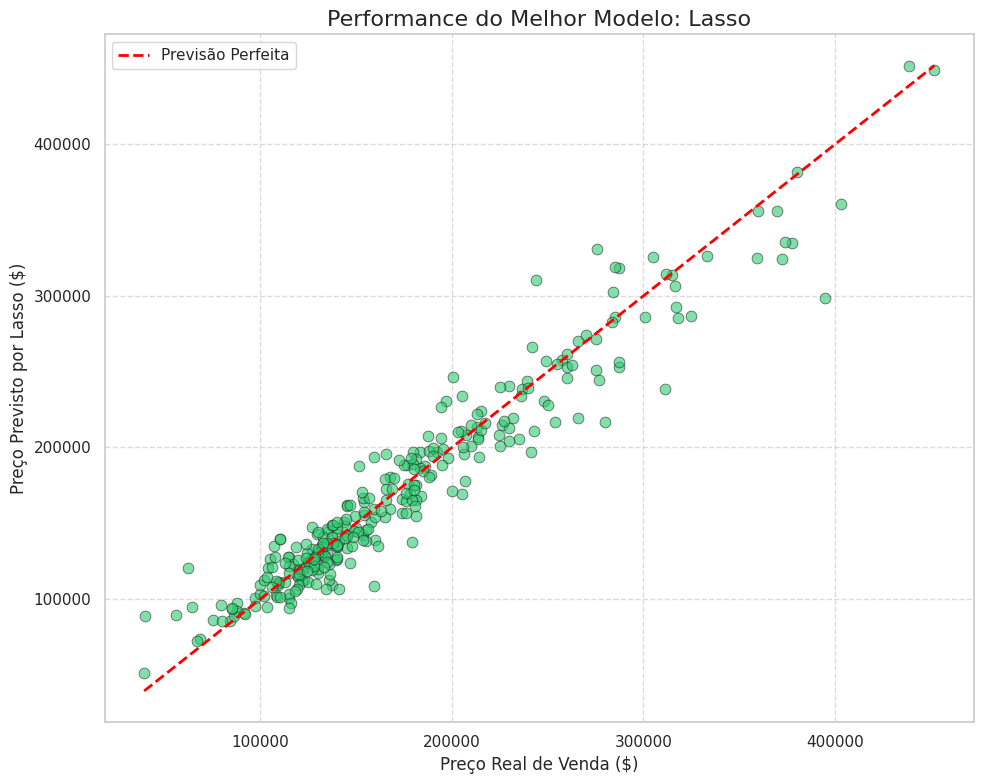

In [ ]:
# 1. Identificar automaticamente o melhor modelo baseado no RMSE
if 'results_data' in globals() and len(results_data) > 0:
    # Encontra o dicionário com o menor valor na chave 'RMSE'
    best_result = min(results_data, key=lambda x: x['RMSE'])
    champion_name = best_result['Modelo']
    champion_model = best_models[champion_name]

    print(f"O modelo campeão foi: {champion_name} (RMSE: {best_result['RMSE']:,.2f})")
    print("Gerando gráfico para este modelo...")

    # 2. Realizar Previsões no Teste com o Campeão
    y_pred_log = champion_model.predict(X_test)

    # 3. Reverter a escala Logarítmica para Dólares Reais
    y_real = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)

    # 4. Configuração do Gráfico
    plt.figure(figsize=(10, 8))

    # Plot dos pontos (Dispersão)
    sns.scatterplot(x=y_real, y=y_pred, alpha=0.6, color="#2ecc71", edgecolor="k", s=60)

    # Linha de Identidade (Perfeição: y = x)
    max_val = max(y_real.max(), y_pred.max())
    min_val = min(y_real.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Previsão Perfeita')

    # Títulos e Etiquetas
    plt.title(f"Performance do Melhor Modelo: {champion_name}", fontsize=16)
    plt.xlabel("Preço Real de Venda ($)", fontsize=12)
    plt.ylabel(f"Preço Previsto por {champion_name} ($)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

else:
    print("Erro: Resultados não encontrados. Execute a Célula 8 primeiro.")